In [4]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm

import sys

from scipy.stats import norm, multivariate_normal, beta, binom, stats
from scipy.stats import t as stats_t
from scipy.special import beta as beta_func
from scipy.special import binom as special_binom
from scipy.special import betaln as special_betaln
from scipy.optimize import fmin
from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# My MCMC

In [5]:
def proposed_jump(theta, mu, sigma, bounds = [0, 1]):
    low_bound = bounds[0]
    high_bound = bounds[1]    
    new_theta = theta + np.random.normal(mu, sigma)
    if high_bound >= new_theta >= low_bound:
        return new_theta
    else:
        return theta
    
def prob_func(theta, mu = .5, sigma = 1):
    return (1/np.sqrt(2 * np.pi * sigma * sigma)) * np.e ** -(((theta - mu) ** 2) / (2 * sigma * sigma))

def jump_prob(theta, mu, sigma):
    new_theta = proposed_jump(theta, mu, sigma)
    return prob_func(new_theta, mu, sigma), new_theta
    
def accept_jump(prob_func, jump_prob):
    if min(1, (jump_prob / prob_func)) != 1:
        prob_of_jump = np.random.normal()
        if (jump_prob / prob_func) > prob_of_jump:
            return True
        elif (jump_prob / prob_func) <= prob_of_jump:
            return False
    else:
        return True

In [6]:
def MCMC(num_steps, mu, sigma):
    theta = np.random.uniform(0,1)
    thetas = [theta]
    step = np.arange(num_steps)
    for i in range(num_steps - 1):
        maybe_jump, new_theta = jump_prob(thetas[-1], mu, sigma)
        if accept_jump(prob_func(thetas[-1], mu, sigma), maybe_jump):
            thetas.append(new_theta)
        else:
            thetas.append(thetas[-1])
    return np.asarray(thetas), step

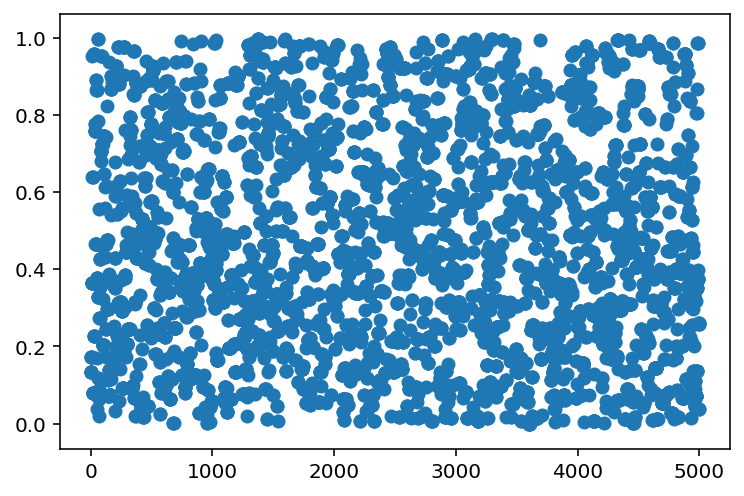

In [7]:
num_steps = 5000
theta, step = MCMC(num_steps, 0, 1)
plt.scatter(step, theta);

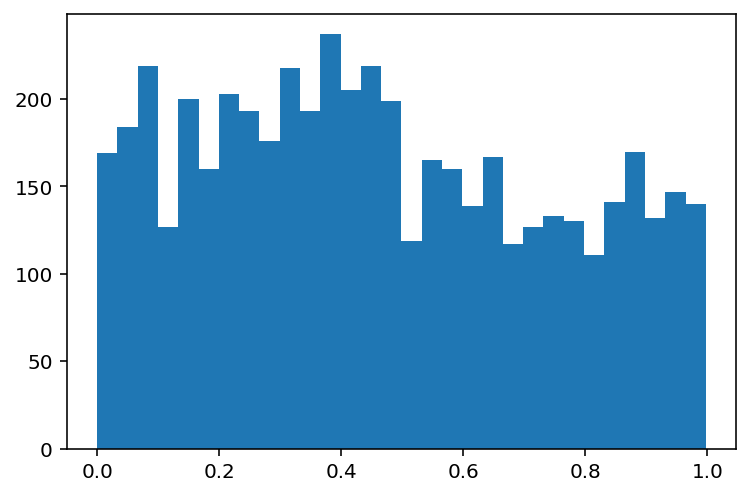

In [8]:
plt.hist(theta, bins = 30);

# Problem 7.1

In [9]:
"""plot_post.py"""

def plot_post(param_sample_vec, cred_mass=0.95, comp_val=False,
              ROPE=False, ylab='', xlab='parameter', fontsize = 14, labelsize=14,
              title='', framealpha=1, facecolor='skyblue', edgecolor='white',
              show_mode=True, bins=50):
    
    #compute HDI
    HDI = hpd(param_sample_vec, 1-cred_mass)

    post_summary = {'mean':0,'median':0,'mode':0, 'hdi_mass':0,'hdi_low':0,
                   'hdi_high':0, 'comp_val':0, 'pc_gt_comp_val':0, 'ROPE_low':0,
                   'ROPE_high':0, 'pc_in_ROPE':0}
    post_summary['mean'] = np.mean(param_sample_vec)
    post_summary['median'] = np.median(param_sample_vec)
    post_summary['mode'] = stats.mode(param_sample_vec)[0]
    post_summary['hdi_mass'] = cred_mass
    post_summary['hdi_low'] = HDI[0]
    post_summary['hdi_high'] = HDI[1]

    # Plot histogram.
    n, bins, patches = plt.hist(param_sample_vec, normed=True, bins=bins,
                                edgecolor=edgecolor, facecolor=facecolor)
    #plt.xlabel('xlab', fontsize=14)
    #plt.ylabel('ylab', fontsize=14)
    #plt.title('title', fontsize=14)

    cv_ht = 0.75*np.max(n)
    cen_tend_ht = 0.9 * cv_ht
    ROPE_text_ht = 0.55 * cv_ht
#    # Display mean or mode:
    if show_mode:
        plt.plot(0, label='mode = %.2f' % post_summary['mode'], alpha=0)
    else:
        plt.plot(0, label='mean = %.2f' % post_summary['mean'], alpha=0)
    # Display the comparison value.

    if comp_val is not False:
        pc_gt_comp_val = 100 * np.sum(param_sample_vec > comp_val)/len(param_sample_vec)
        pc_lt_comp_val = 100 - pc_gt_comp_val
        plt.plot([comp_val, comp_val], [0, cv_ht], color='darkgreen',
                 linestyle='--', linewidth=2,
                 label='%.1f%% <%.1f < %.1f%%'
                 % (pc_lt_comp_val, comp_val, pc_gt_comp_val))
        post_summary['comp_val'] = comp_val
        post_summary['pc_gt_comp_val'] = pc_gt_comp_val
#    # Display the ROPE.
    if ROPE is not False:
        rope_col = 'darkred'
        pc_in_ROPE = round(np.sum((param_sample_vec > ROPE[0]) & (param_sample_vec < ROPE[1]))/len(param_sample_vec)*100)
        plt.plot([ROPE[0], ROPE[0]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4,
                label='%.1f%% in ROPE' % pc_in_ROPE)
        plt.plot([ROPE[1], ROPE[1]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4)
        post_summary['ROPE_low'] = ROPE[0] 
        post_summary['ROPE_high'] = ROPE[1] 
        post_summary['pc_in_ROPE'] = pc_in_ROPE
#    # Display the HDI.
    plt.plot(HDI, [0, 0], linewidth=6, color='k', label='HDI %.1f%% %.3f-%.3f' % (cred_mass*100, HDI[0], HDI[1]))
    plt.legend(loc='upper left', fontsize=labelsize, framealpha=framealpha)
    return post_summary

In [10]:
def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


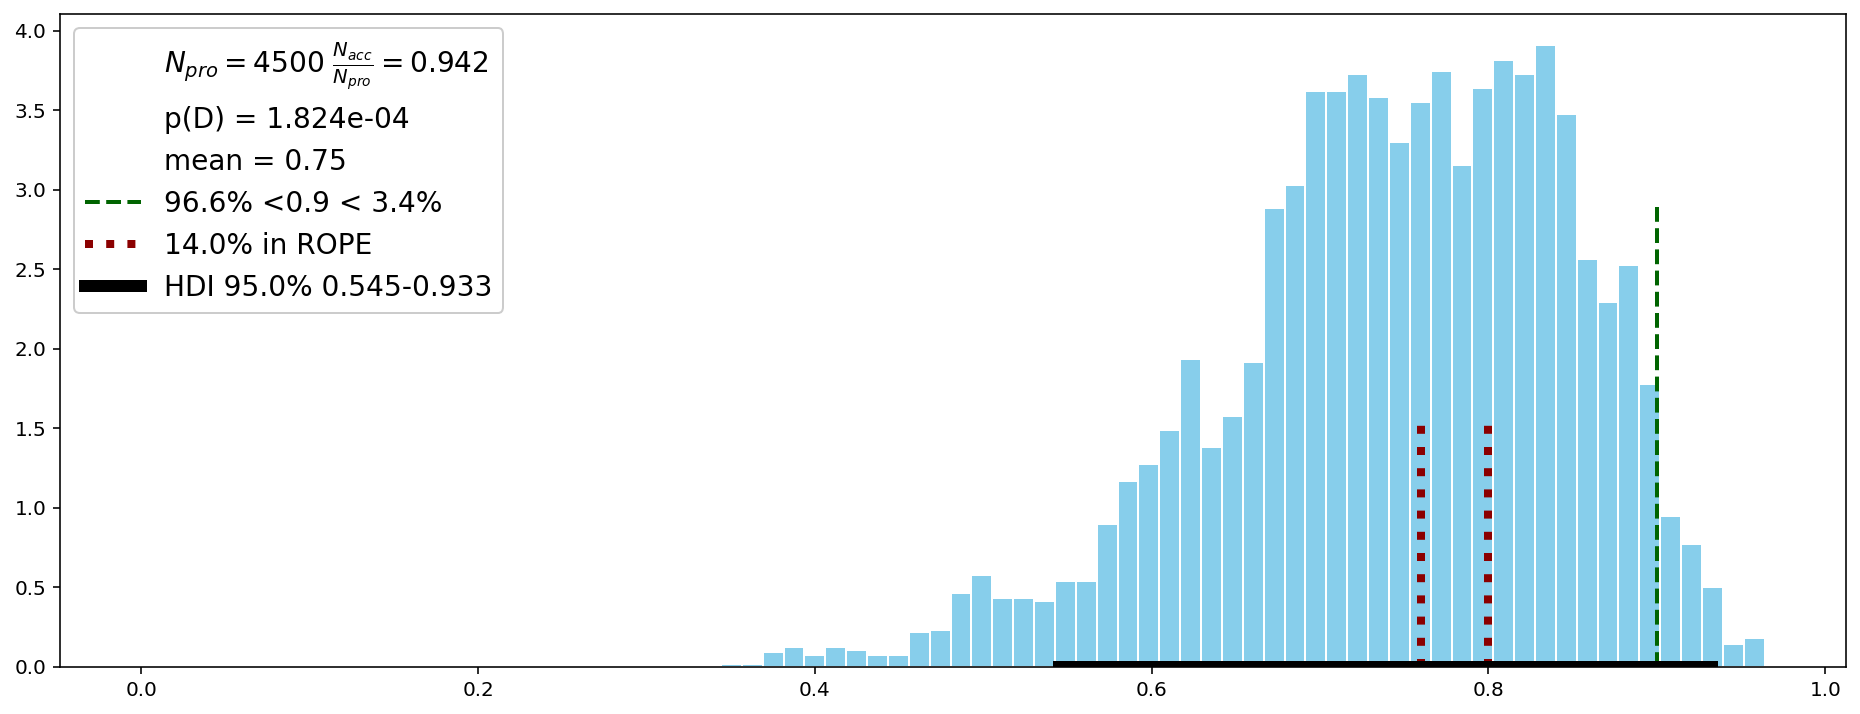

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


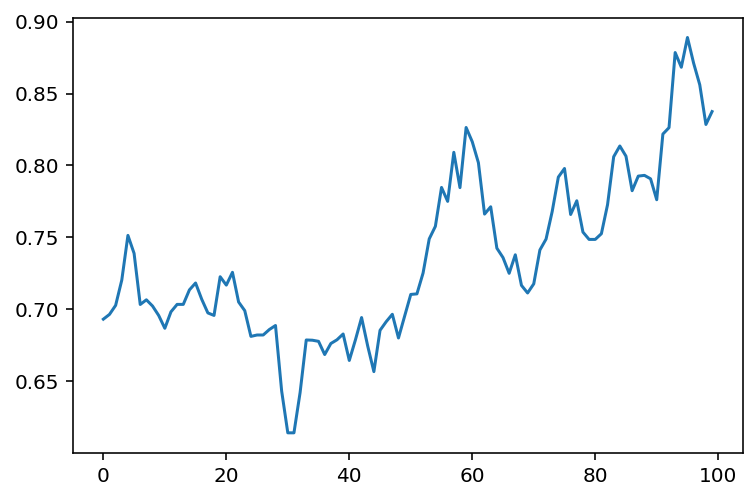

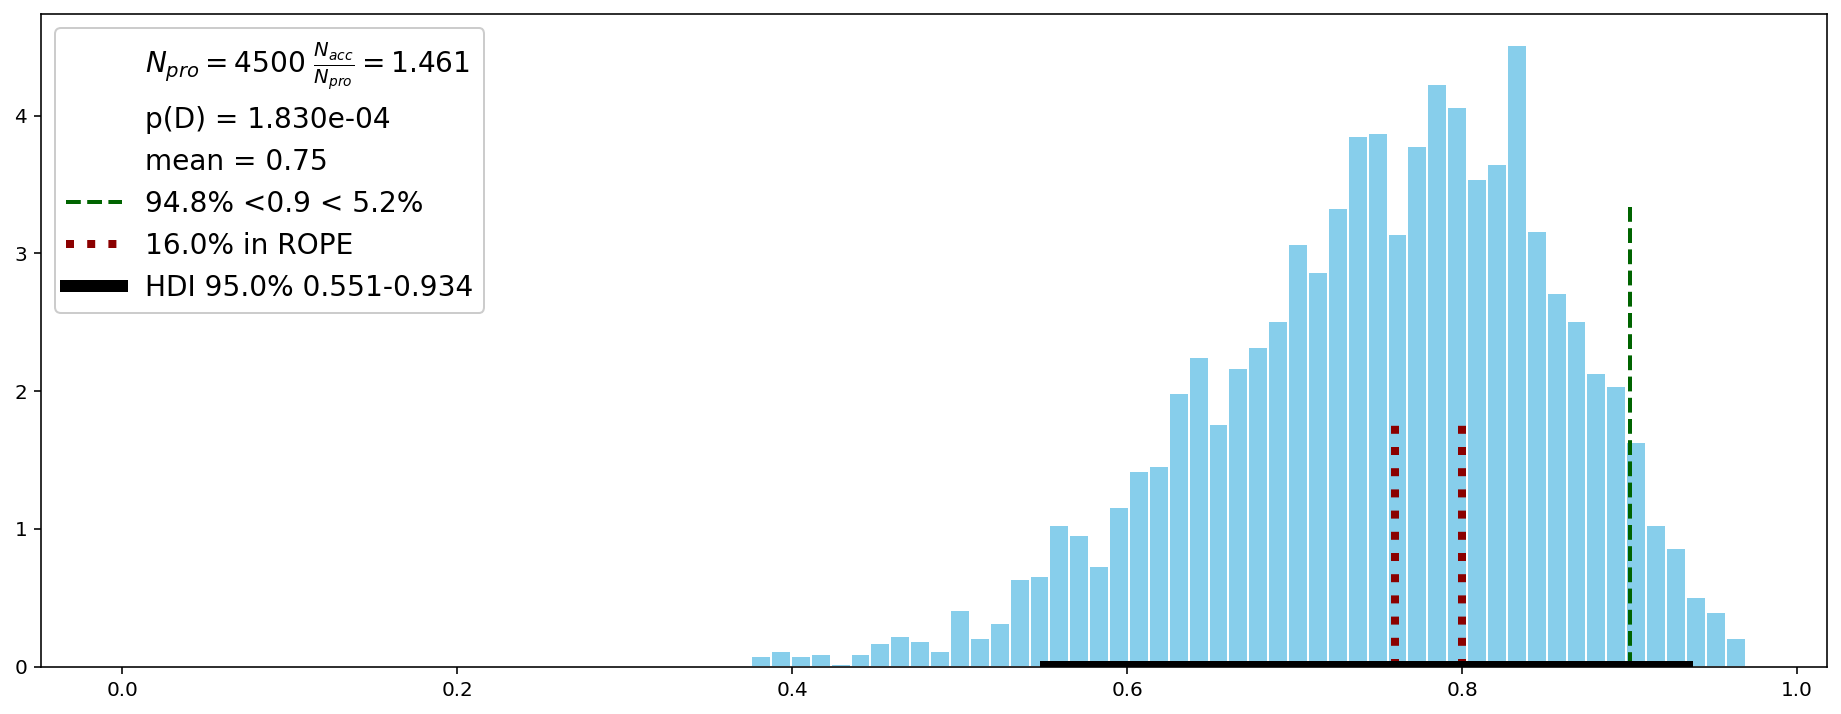

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


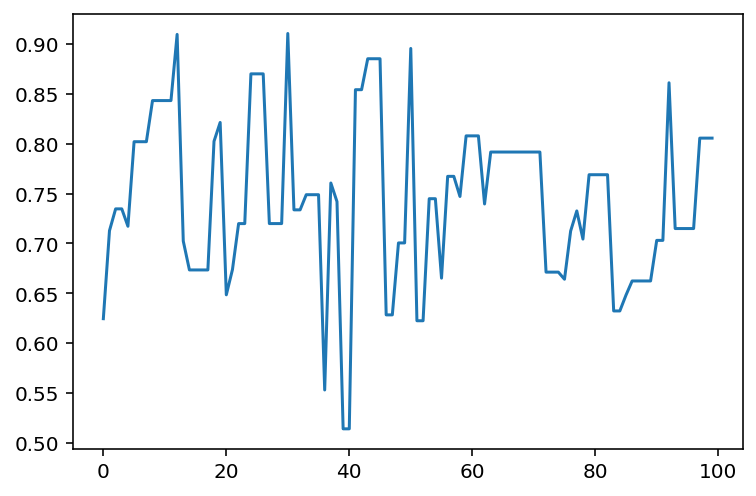

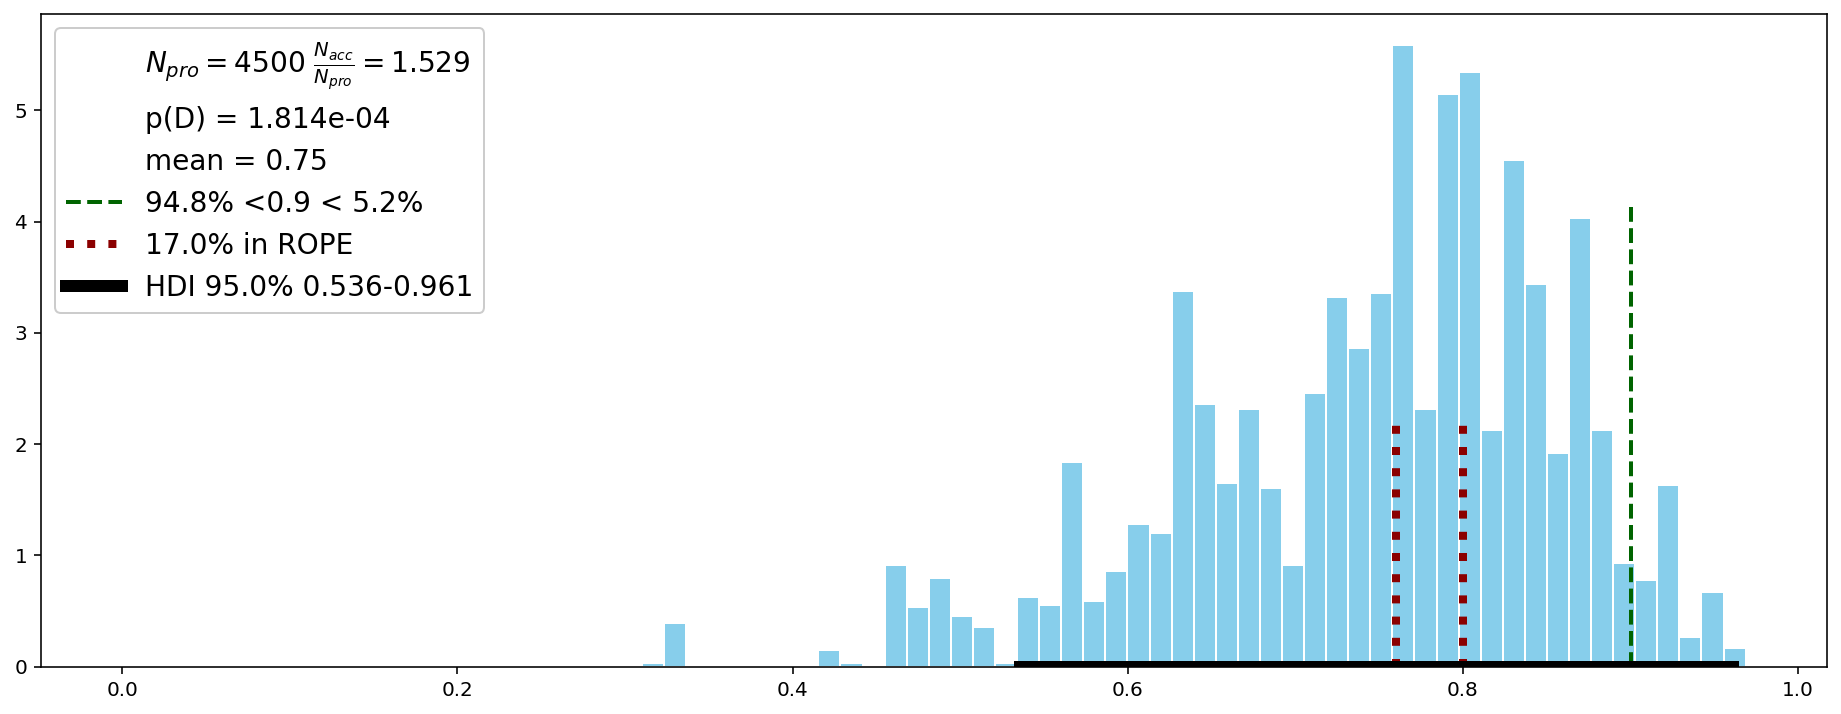

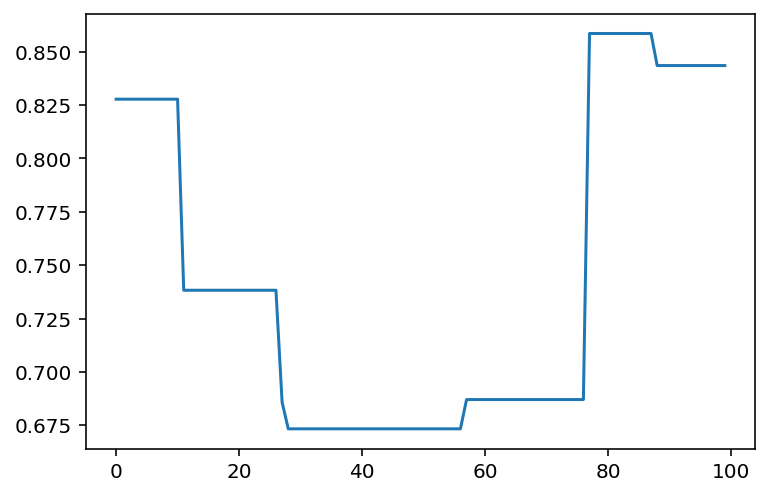

In [28]:
"""
07_BernMetropolisTemplate.py
Use this program as a template for experimenting with the Metropolis algorithm
applied to a single parameter called theta, defined on the interval [0,1].
"""

# Specify the data, to be used in the likelihood function.
# This is a vector with one component per flip,
# in which 1 means a "head" and 0 means a "tail".
my_data = np.repeat([1, 0], [11, 3])  # 11 heads, 2 tail

# Define the Bernoulli likelihood function, p(D|theta).
# The argument theta could be a vector, not just a scalar.
def likelihood(theta, data):
    theta = np.array(theta) # ensure you have an array
    z = sum(data[data == 1])  # number of 1's in Data
    N = len(data)  # number of flips in Data
# Compute the likelihood of the Data for each value of Theta.
    if np.size(theta) == 1:  # if theta is an scalar
        p_data_given_theta = 0
        if theta < 1 and theta > 0:
            p_data_given_theta = theta**z * (1-theta)**(N-z)
    else: # if theta is an array
        p_data_given_theta = theta**z * (1-theta)**(N-z)
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        p_data_given_theta[(theta > 1) | (theta < 0)] = 0
    return p_data_given_theta


# Define the prior density function. For purposes of computing p(D),
# at the end of this program, we want this prior to be a proper density.
# The argument theta could be a vector, not just a scalar.
def prior(theta):
    theta = np.array(theta) # ensure you have an array
# For kicks, here's a bimodal prior. To try it, uncomment the next 2 lines.
    #from scipy.stats import beta
    #prior = dbeta(np.minium(2*theta, 2*(1-theta)), 2, 2)
    if np.size(theta) == 1:  # if theta is an scalar
        prior = 0
        if theta < 1 and theta > 0:
            prior = 1
    else: # if theta is an array
        prior = np.ones(len(theta))  # uniform density over [0,1]
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        prior[(theta > 1) | (theta < 0)] = 0
    return prior



# Define the relative probability of the target distribution, 
# as a function of vector theta. For our application, this
# target distribution is the unnormalized posterior distribution.
def target_rel_prob(theta, data):
    target_rel_prob = likelihood(theta , data) * prior(theta)
    return target_rel_prob

# Specify the length of the trajectory, i.e., the number of jumps to try:
traj_length = 5000 # arbitrary large number
# Initialize the vector that will store the results:
trajectory = np.zeros(traj_length)
# Specify where to start the trajectory:
trajectory[0] = 0.50 # arbitrary value
# Specify the burn-in period:
burn_in = int(np.ceil(0.1 * traj_length)) # arbitrary number, less than traj_length
# Initialize accepted, rejected counters, just to monitor performance:
n_accepted = 0
n_rejected = 0
# Specify seed to reproduce same random walk:
#np.random.seed(4745)

# Now generate the random walk. The 't' index is time or trial in the walk.
for i in range(3):   
    for t in range(traj_length-1):
        current_position = trajectory[t]
        # Use the proposal distribution to generate a proposed jump.
        # The shape and variance of the proposal distribution can be changed
        # to whatever you think is appropriate for the target distribution.
        proposalSD = [.02, .2, 2.]
        proposed_jump = np.random.normal(loc=0 , scale=proposalSD[i], size=1)

    #    # Compute the probability of accepting the proposed jump.
        prob_accept = np.minimum(1, 
                                target_rel_prob(current_position + proposed_jump, my_data)
                                / target_rel_prob(current_position, my_data))
    #    # Generate a random uniform value from the interval [0,1] to
    #    # decide whether or not to accept the proposed jump.
        if np.random.rand() < prob_accept:
            # accept the proposed jump
            trajectory[t+1] = current_position + proposed_jump
            # increment the accepted counter, just to monitor performance
            if t > burn_in:
                n_accepted += 1
        else:
            # reject the proposed jump, stay at current position
            trajectory[t+1] = current_position
            # increment the rejected counter, just to monitor performance
            if t > burn_in:
                n_rejected += 1


    # Extract the post-burn_in portion of the trajectory.
    accepted_traj = trajectory[burn_in:]
    # End of Metropolis algorithm.



    # Display rejected/accepted ratio in the plot.
    mean_traj = np.mean(accepted_traj)
    std_traj = np.std(accepted_traj)

    plt.figure(figsize=(16,6)) # Brian added

    plt.plot(0, label=r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(accepted_traj), (n_accepted/len(accepted_traj))), alpha=0)

    # Evidence for model, p(D).

    # Compute a,b parameters for beta distribution that has the same mean
    # and stdev as the sample from the posterior. This is a useful choice
    # when the likelihood function is Bernoulli.
    a = mean_traj * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)
    b = (1 - mean_traj) * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)

    # For every theta value in the posterior sample, compute 
    # dbeta(theta,a,b) / likelihood(theta)*prior(theta)
    # This computation assumes that likelihood and prior are proper densities,
    # i.e., not just relative probabilities. This computation also assumes that
    # the likelihood and prior functions were defined to accept a vector argument,
    # not just a single-component scalar argument.
    wtd_evid = beta.pdf(accepted_traj, a, b) / (likelihood(accepted_traj, my_data) * prior(accepted_traj))
    p_data = 1 / np.mean(wtd_evid)


    # Display p(D) in the graph
    plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)

    # Display the posterior.
    ROPE = np.array([0.76, 0.8])
    mcmc_info = plot_post(accepted_traj, xlab='theta', show_mode=False, comp_val=0.9, ROPE=ROPE)


    # Uncomment next line if you want to save the graph.
    plt.show()
    plt.plot(np.arange(len(accepted_traj[:100])), accepted_traj[:100])

The paths that each of the walks with different standard deviations on the step size look almost identical to the paths that are shown in the book. The ESS tends to go down as SD on the step size decreases. This is due to the step sizes being out of bounds or too big to really go anywhere useful. The standard deviation on the step size needs to be small compared to parameter space; using the SD of 2 is terrible because a lot of the values it will chose are greater than 1 while using the SD of 0.02 is a lille bit of overkill because it doesn't do a good job of walking through all of parameter space. 

# Problem 7.3

B)

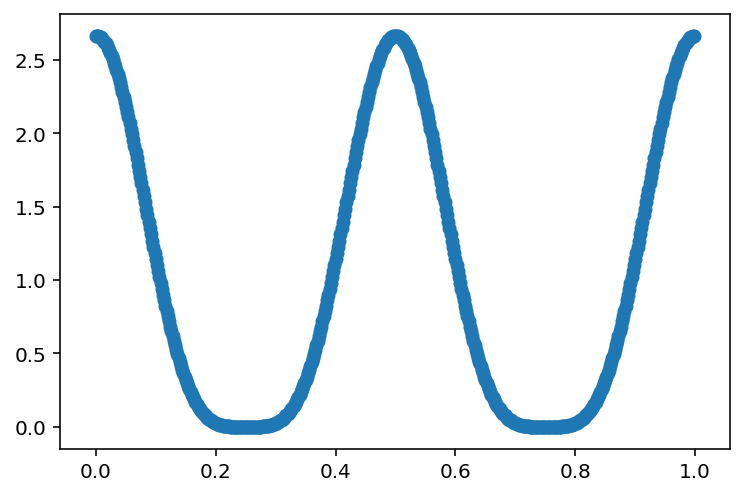

In [14]:
x = np.arange(0,1,1/500)
plt.scatter(x, [prior(theta) for theta in x])

C)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


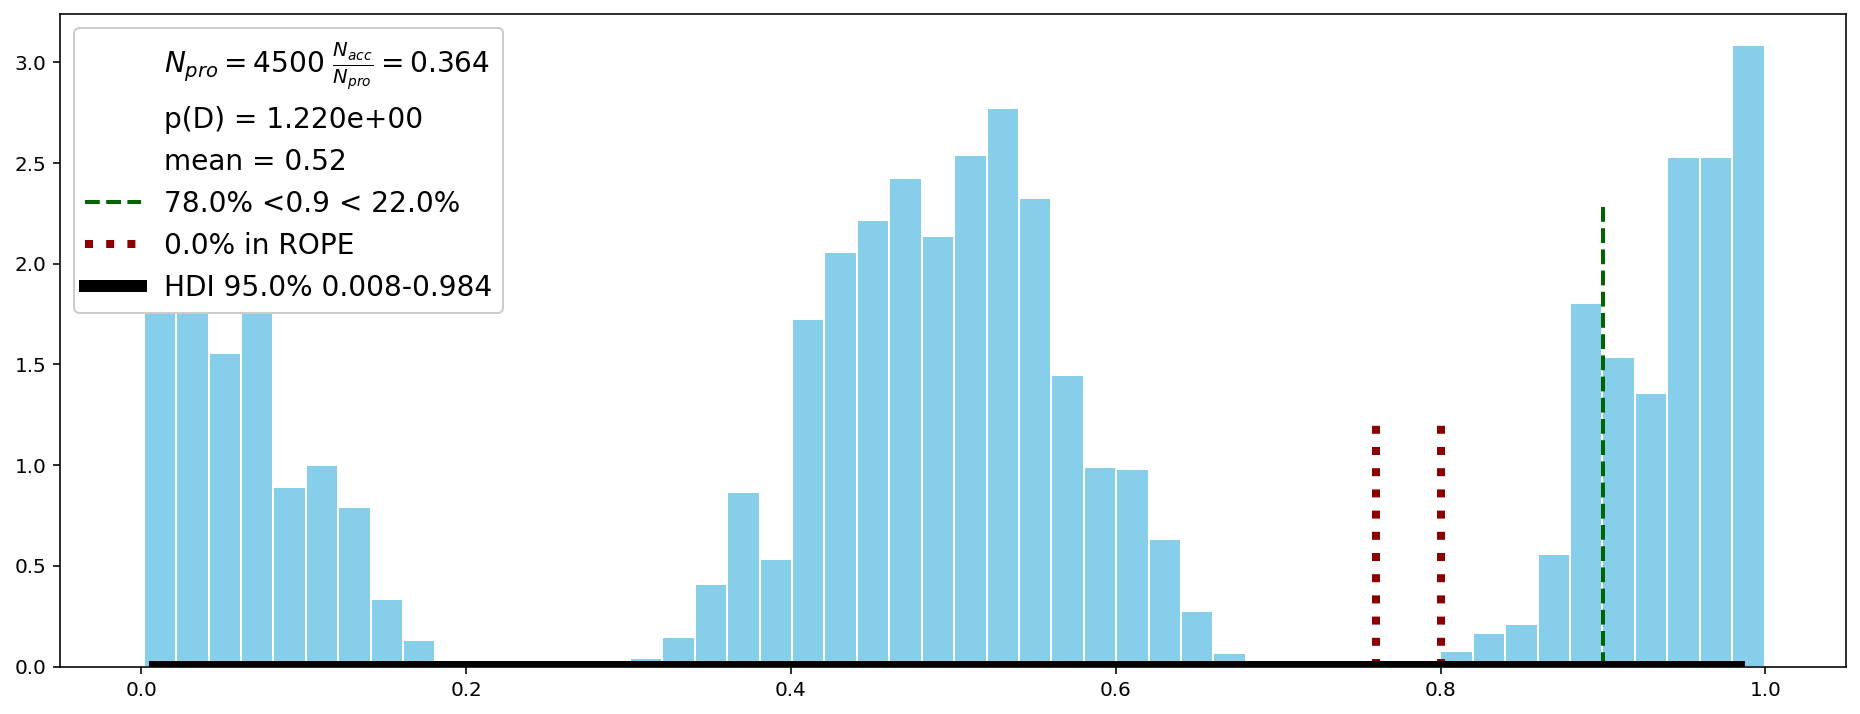

In [32]:
"""
07_BernMetropolisTemplate.py
Use this program as a template for experimenting with the Metropolis algorithm
applied to a single parameter called theta, defined on the interval [0,1].
"""

# Specify the data, to be used in the likelihood function.
# This is a vector with one component per flip,
# in which 1 means a "head" and 0 means a "tail".
my_data = []  # 11 heads, 2 tail

# Define the Bernoulli likelihood function, p(D|theta).
# The argument theta could be a vector, not just a scalar.
def likelihood(theta, data):
    theta = np.array(theta) # ensure you have an array
    z = 0  # number of 1's in Data
    N = 0  # number of flips in Data
# Compute the likelihood of the Data for each value of Theta.
    if np.size(theta) == 1:  # if theta is an scalar
        p_data_given_theta = 0
        if theta < 1 and theta > 0:
            p_data_given_theta = theta**z * (1-theta)**(N-z)
    else: # if theta is an array
        p_data_given_theta = theta**z * (1-theta)**(N-z)
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        p_data_given_theta[(theta > 1) | (theta < 0)] = 0
    return p_data_given_theta


# Define the prior density function. For purposes of computing p(D),
# at the end of this program, we want this prior to be a proper density.
# The argument theta could be a vector, not just a scalar.
def prior(theta):
    """theta = np.array(theta) # ensure you have an array
# For kicks, here's a bimodal prior. To try it, uncomment the next 2 lines.
    #from scipy.stats import beta
    #prior = dbeta(np.minium(2*theta, 2*(1-theta)), 2, 2)
    if np.size(theta) == 1:  # if theta is an scalar
        prior = 0
        if theta < 1 and theta > 0:
            prior = 1
    else: # if theta is an array
        prior = np.ones(len(theta))  # uniform density over [0,1]
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        prior[(theta > 1) | (theta < 0)] = 0
    return prior"""
    return (1/1.5) * ((np.cos(4 * np.pi * theta) + 1) ** 2)



# Define the relative probability of the target distribution, 
# as a function of vector theta. For our application, this
# target distribution is the unnormalized posterior distribution.
def target_rel_prob(theta, data):
    target_rel_prob = likelihood(theta , data) * prior(theta)
    return target_rel_prob

# Specify the length of the trajectory, i.e., the number of jumps to try:
traj_length = 5000 # arbitrary large number
# Initialize the vector that will store the results:
trajectory = np.zeros(traj_length)
# Specify where to start the trajectory:
trajectory[0] = 0.50 # arbitrary value
# Specify the burn-in period:
burn_in = int(np.ceil(0.1 * traj_length)) # arbitrary number, less than traj_length
# Initialize accepted, rejected counters, just to monitor performance:
n_accepted = 0
n_rejected = 0
# Specify seed to reproduce same random walk:
np.random.seed(4745)

# Now generate the random walk. The 't' index is time or trial in the walk.
for t in range(traj_length-1):
    current_position = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    # The shape and variance of the proposal distribution can be changed
    # to whatever you think is appropriate for the target distribution.
    proposalSD = [.02, .2, 2.]
    proposed_jump = np.random.normal(loc=0 , scale=proposalSD[1], size=1)

#    # Compute the probability of accepting the proposed jump.
    prob_accept = np.minimum(1, 
                            target_rel_prob(current_position + proposed_jump, my_data)
                            / target_rel_prob(current_position, my_data))
#    # Generate a random uniform value from the interval [0,1] to
#    # decide whether or not to accept the proposed jump.
    if np.random.rand() < prob_accept:
        # accept the proposed jump
        trajectory[t+1] = current_position + proposed_jump
        # increment the accepted counter, just to monitor performance
        if t > burn_in:
            n_accepted += 1
    else:
        # reject the proposed jump, stay at current position
        trajectory[t+1] = current_position
        # increment the rejected counter, just to monitor performance
        if t > burn_in:
            n_rejected += 1


# Extract the post-burn_in portion of the trajectory.
accepted_traj = trajectory[burn_in:]
# End of Metropolis algorithm.



# Display rejected/accepted ratio in the plot.
mean_traj = np.mean(accepted_traj)
std_traj = np.std(accepted_traj)

plt.figure(figsize=(16,6)) # Brian added

plt.plot(0, label=r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(accepted_traj), (n_accepted/len(accepted_traj))), alpha=0)

# Evidence for model, p(D).

# Compute a,b parameters for beta distribution that has the same mean
# and stdev as the sample from the posterior. This is a useful choice
# when the likelihood function is Bernoulli.
a = mean_traj * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)
b = (1 - mean_traj) * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)

# For every theta value in the posterior sample, compute 
# dbeta(theta,a,b) / likelihood(theta)*prior(theta)
# This computation assumes that likelihood and prior are proper densities,
# i.e., not just relative probabilities. This computation also assumes that
# the likelihood and prior functions were defined to accept a vector argument,
# not just a single-component scalar argument.
wtd_evid = beta.pdf(accepted_traj, a, b) / (likelihood(accepted_traj, my_data) * prior(accepted_traj))
p_data = 1 / np.mean(wtd_evid)


# Display p(D) in the graph
plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)

# Display the posterior.
ROPE = np.array([0.76, 0.8])
mcmc_info = plot_post(accepted_traj, xlab='theta', show_mode=False, comp_val=0.9, ROPE=ROPE)


# Uncomment next line if you want to save the graph.
plt.show()

The graph looks very similar to the graph of the prior function which is good.

D)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


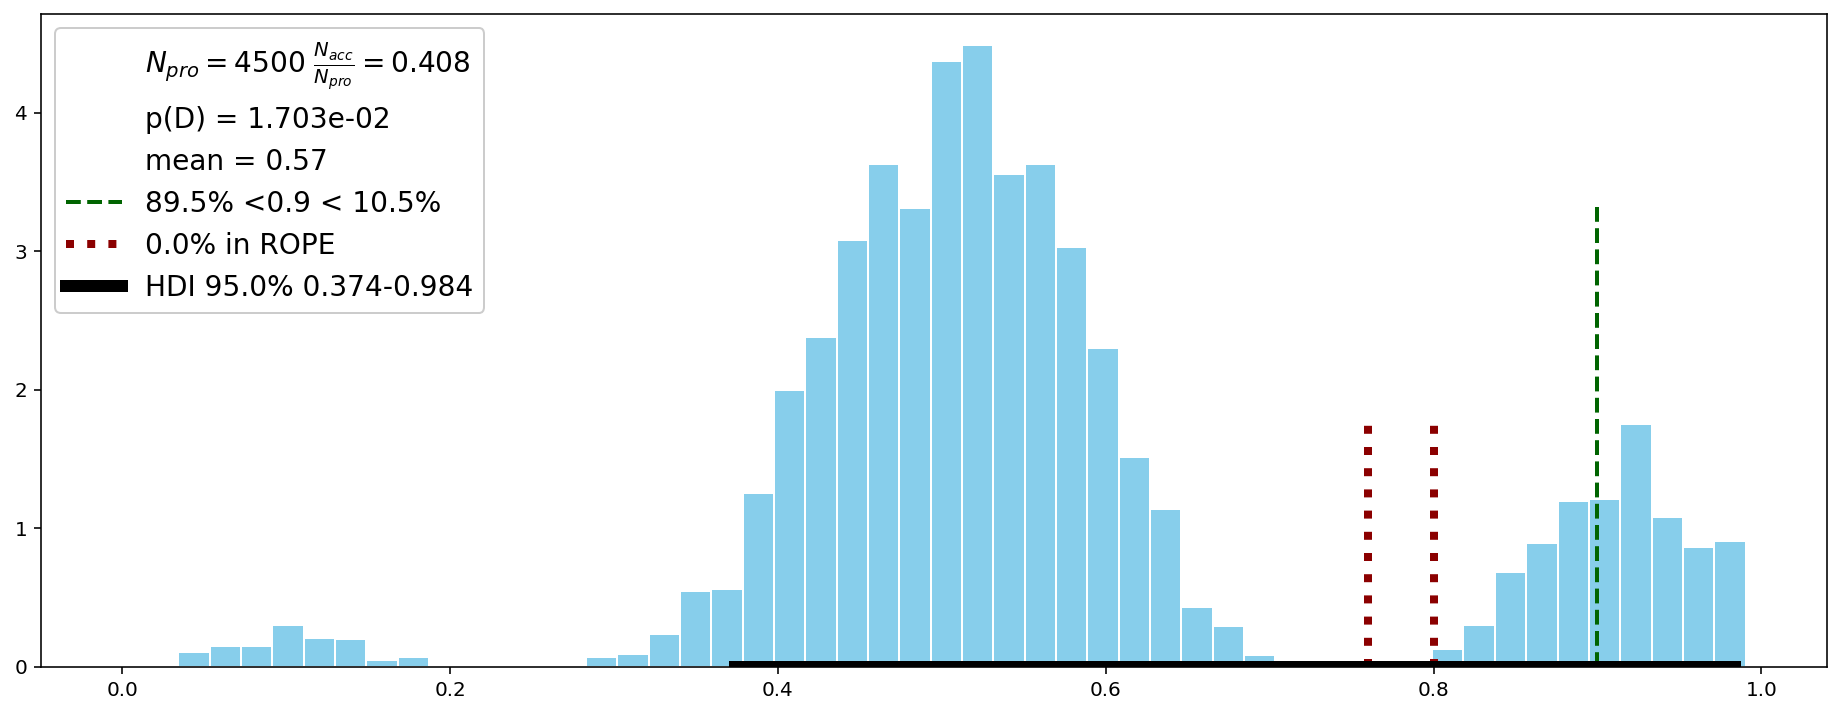

In [16]:
"""
07_BernMetropolisTemplate.py
Use this program as a template for experimenting with the Metropolis algorithm
applied to a single parameter called theta, defined on the interval [0,1].
"""

# Specify the data, to be used in the likelihood function.
# This is a vector with one component per flip,
# in which 1 means a "head" and 0 means a "tail".
my_data = np.array([0,1,1])  # 11 heads, 2 tail

# Define the Bernoulli likelihood function, p(D|theta).
# The argument theta could be a vector, not just a scalar.
def likelihood(theta, data):
    theta = np.array(theta) # ensure you have an array
    z = sum(data[data == 1])  # number of 1's in Data
    N = len(data)  # number of flips in Data
# Compute the likelihood of the Data for each value of Theta.
    if np.size(theta) == 1:  # if theta is an scalar
        p_data_given_theta = 0
        if theta < 1 and theta > 0:
            p_data_given_theta = theta**z * (1-theta)**(N-z)
    else: # if theta is an array
        p_data_given_theta = theta**z * (1-theta)**(N-z)
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        p_data_given_theta[(theta > 1) | (theta < 0)] = 0
    return p_data_given_theta


# Define the prior density function. For purposes of computing p(D),
# at the end of this program, we want this prior to be a proper density.
# The argument theta could be a vector, not just a scalar.
def prior(theta):
    """theta = np.array(theta) # ensure you have an array
# For kicks, here's a bimodal prior. To try it, uncomment the next 2 lines.
    #from scipy.stats import beta
    #prior = dbeta(np.minium(2*theta, 2*(1-theta)), 2, 2)
    if np.size(theta) == 1:  # if theta is an scalar
        prior = 0
        if theta < 1 and theta > 0:
            prior = 1
    else: # if theta is an array
        prior = np.ones(len(theta))  # uniform density over [0,1]
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        prior[(theta > 1) | (theta < 0)] = 0
    return prior"""
    return (1/1.5) * ((np.cos(4 * np.pi * theta) + 1) ** 2)



# Define the relative probability of the target distribution, 
# as a function of vector theta. For our application, this
# target distribution is the unnormalized posterior distribution.
def target_rel_prob(theta, data):
    target_rel_prob = likelihood(theta , data) * prior(theta)
    return target_rel_prob

# Specify the length of the trajectory, i.e., the number of jumps to try:
traj_length = 5000 # arbitrary large number
# Initialize the vector that will store the results:
trajectory = np.zeros(traj_length)
# Specify where to start the trajectory:
trajectory[0] = 0.50 # arbitrary value
# Specify the burn-in period:
burn_in = int(np.ceil(0.1 * traj_length)) # arbitrary number, less than traj_length
# Initialize accepted, rejected counters, just to monitor performance:
n_accepted = 0
n_rejected = 0
# Specify seed to reproduce same random walk:
np.random.seed(4745)

# Now generate the random walk. The 't' index is time or trial in the walk.
for t in range(traj_length-1):
    current_position = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    # The shape and variance of the proposal distribution can be changed
    # to whatever you think is appropriate for the target distribution.
    proposalSD = [.02, .2, 2.]
    proposed_jump = np.random.normal(loc=0 , scale=proposalSD[1], size=1)

#    # Compute the probability of accepting the proposed jump.
    prob_accept = np.minimum(1, 
                            target_rel_prob(current_position + proposed_jump, my_data)
                            / target_rel_prob(current_position, my_data))
#    # Generate a random uniform value from the interval [0,1] to
#    # decide whether or not to accept the proposed jump.
    if np.random.rand() < prob_accept:
        # accept the proposed jump
        trajectory[t+1] = current_position + proposed_jump
        # increment the accepted counter, just to monitor performance
        if t > burn_in:
            n_accepted += 1
    else:
        # reject the proposed jump, stay at current position
        trajectory[t+1] = current_position
        # increment the rejected counter, just to monitor performance
        if t > burn_in:
            n_rejected += 1


# Extract the post-burn_in portion of the trajectory.
accepted_traj = trajectory[burn_in:]
# End of Metropolis algorithm.



# Display rejected/accepted ratio in the plot.
mean_traj = np.mean(accepted_traj)
std_traj = np.std(accepted_traj)

plt.figure(figsize=(16,6)) # Brian added

plt.plot(0, label=r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(accepted_traj), (n_accepted/len(accepted_traj))), alpha=0)

# Evidence for model, p(D).

# Compute a,b parameters for beta distribution that has the same mean
# and stdev as the sample from the posterior. This is a useful choice
# when the likelihood function is Bernoulli.
a = mean_traj * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)
b = (1 - mean_traj) * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)

# For every theta value in the posterior sample, compute 
# dbeta(theta,a,b) / likelihood(theta)*prior(theta)
# This computation assumes that likelihood and prior are proper densities,
# i.e., not just relative probabilities. This computation also assumes that
# the likelihood and prior functions were defined to accept a vector argument,
# not just a single-component scalar argument.
wtd_evid = beta.pdf(accepted_traj, a, b) / (likelihood(accepted_traj, my_data) * prior(accepted_traj))
p_data = 1 / np.mean(wtd_evid)


# Display p(D) in the graph
plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)

# Display the posterior.
ROPE = np.array([0.76, 0.8])
mcmc_info = plot_post(accepted_traj, xlab='theta', show_mode=False, comp_val=0.9, ROPE=ROPE)


# Uncomment next line if you want to save the graph.
plt.show()

This graph looks much less like the original prior. This is due to the SD being a bit too big to wander parameter space very well. Even .1 for the SD would make the graph look more like the original prior. It also changed because of the data that we input into the prior so it's skewed to the right.

E)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


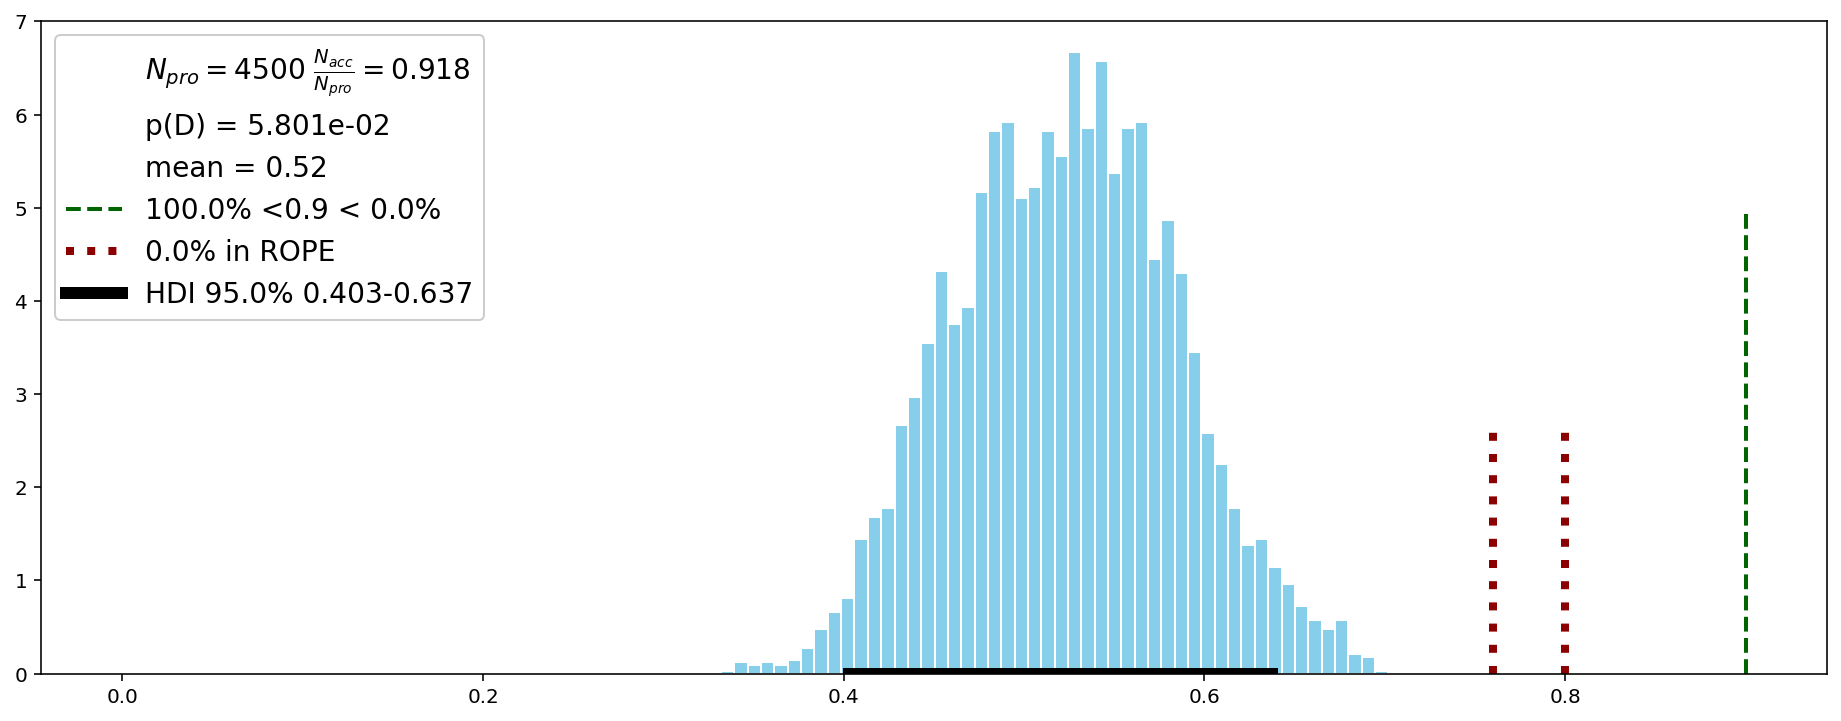

In [17]:
"""
07_BernMetropolisTemplate.py
Use this program as a template for experimenting with the Metropolis algorithm
applied to a single parameter called theta, defined on the interval [0,1].
"""

# Specify the data, to be used in the likelihood function.
# This is a vector with one component per flip,
# in which 1 means a "head" and 0 means a "tail".
my_data = np.array([0,1,1])  # 11 heads, 2 tail

# Define the Bernoulli likelihood function, p(D|theta).
# The argument theta could be a vector, not just a scalar.
def likelihood(theta, data):
    theta = np.array(theta) # ensure you have an array
    z = sum(data[data == 1])  # number of 1's in Data
    N = len(data)  # number of flips in Data
# Compute the likelihood of the Data for each value of Theta.
    if np.size(theta) == 1:  # if theta is an scalar
        p_data_given_theta = 0
        if theta < 1 and theta > 0:
            p_data_given_theta = theta**z * (1-theta)**(N-z)
    else: # if theta is an array
        p_data_given_theta = theta**z * (1-theta)**(N-z)
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        p_data_given_theta[(theta > 1) | (theta < 0)] = 0
    return p_data_given_theta


# Define the prior density function. For purposes of computing p(D),
# at the end of this program, we want this prior to be a proper density.
# The argument theta could be a vector, not just a scalar.
def prior(theta):
    """theta = np.array(theta) # ensure you have an array
# For kicks, here's a bimodal prior. To try it, uncomment the next 2 lines.
    #from scipy.stats import beta
    #prior = dbeta(np.minium(2*theta, 2*(1-theta)), 2, 2)
    if np.size(theta) == 1:  # if theta is an scalar
        prior = 0
        if theta < 1 and theta > 0:
            prior = 1
    else: # if theta is an array
        prior = np.ones(len(theta))  # uniform density over [0,1]
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        prior[(theta > 1) | (theta < 0)] = 0
    return prior"""
    return (1/1.5) * ((np.cos(4 * np.pi * theta) + 1) ** 2)



# Define the relative probability of the target distribution, 
# as a function of vector theta. For our application, this
# target distribution is the unnormalized posterior distribution.
def target_rel_prob(theta, data):
    target_rel_prob = likelihood(theta , data) * prior(theta)
    return target_rel_prob

# Specify the length of the trajectory, i.e., the number of jumps to try:
traj_length = 5000 # arbitrary large number
# Initialize the vector that will store the results:
trajectory = np.zeros(traj_length)
# Specify where to start the trajectory:
trajectory[0] = 0.50 # arbitrary value
# Specify the burn-in period:
burn_in = int(np.ceil(0.1 * traj_length)) # arbitrary number, less than traj_length
# Initialize accepted, rejected counters, just to monitor performance:
n_accepted = 0
n_rejected = 0
# Specify seed to reproduce same random walk:
np.random.seed(4745)

# Now generate the random walk. The 't' index is time or trial in the walk.
for t in range(traj_length-1):
    current_position = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    # The shape and variance of the proposal distribution can be changed
    # to whatever you think is appropriate for the target distribution.
    proposalSD = [.02, .2, 2.]
    proposed_jump = np.random.normal(loc=0 , scale=proposalSD[0], size=1)

#    # Compute the probability of accepting the proposed jump.
    prob_accept = np.minimum(1, 
                            target_rel_prob(current_position + proposed_jump, my_data)
                            / target_rel_prob(current_position, my_data))
#    # Generate a random uniform value from the interval [0,1] to
#    # decide whether or not to accept the proposed jump.
    if np.random.rand() < prob_accept:
        # accept the proposed jump
        trajectory[t+1] = current_position + proposed_jump
        # increment the accepted counter, just to monitor performance
        if t > burn_in:
            n_accepted += 1
    else:
        # reject the proposed jump, stay at current position
        trajectory[t+1] = current_position
        # increment the rejected counter, just to monitor performance
        if t > burn_in:
            n_rejected += 1


# Extract the post-burn_in portion of the trajectory.
accepted_traj = trajectory[burn_in:]
# End of Metropolis algorithm.



# Display rejected/accepted ratio in the plot.
mean_traj = np.mean(accepted_traj)
std_traj = np.std(accepted_traj)

plt.figure(figsize=(16,6)) # Brian added

plt.plot(0, label=r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(accepted_traj), (n_accepted/len(accepted_traj))), alpha=0)

# Evidence for model, p(D).

# Compute a,b parameters for beta distribution that has the same mean
# and stdev as the sample from the posterior. This is a useful choice
# when the likelihood function is Bernoulli.
a = mean_traj * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)
b = (1 - mean_traj) * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)

# For every theta value in the posterior sample, compute 
# dbeta(theta,a,b) / likelihood(theta)*prior(theta)
# This computation assumes that likelihood and prior are proper densities,
# i.e., not just relative probabilities. This computation also assumes that
# the likelihood and prior functions were defined to accept a vector argument,
# not just a single-component scalar argument.
wtd_evid = beta.pdf(accepted_traj, a, b) / (likelihood(accepted_traj, my_data) * prior(accepted_traj))
p_data = 1 / np.mean(wtd_evid)


# Display p(D) in the graph
plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)

# Display the posterior.
ROPE = np.array([0.76, 0.8])
mcmc_info = plot_post(accepted_traj, xlab='theta', show_mode=False, comp_val=0.9, ROPE=ROPE)


# Uncomment next line if you want to save the graph.
plt.show()

This clearly shows that our SD is too small. We are getting stuck in the middle hump and because the step size is always really small, it would take an astronomically large amount of time to walk parameter space well enough to get a good distribution that looked like the graph from part B. We can check this by either changing our SD or by changing our starting location as we do in the next part.

F)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


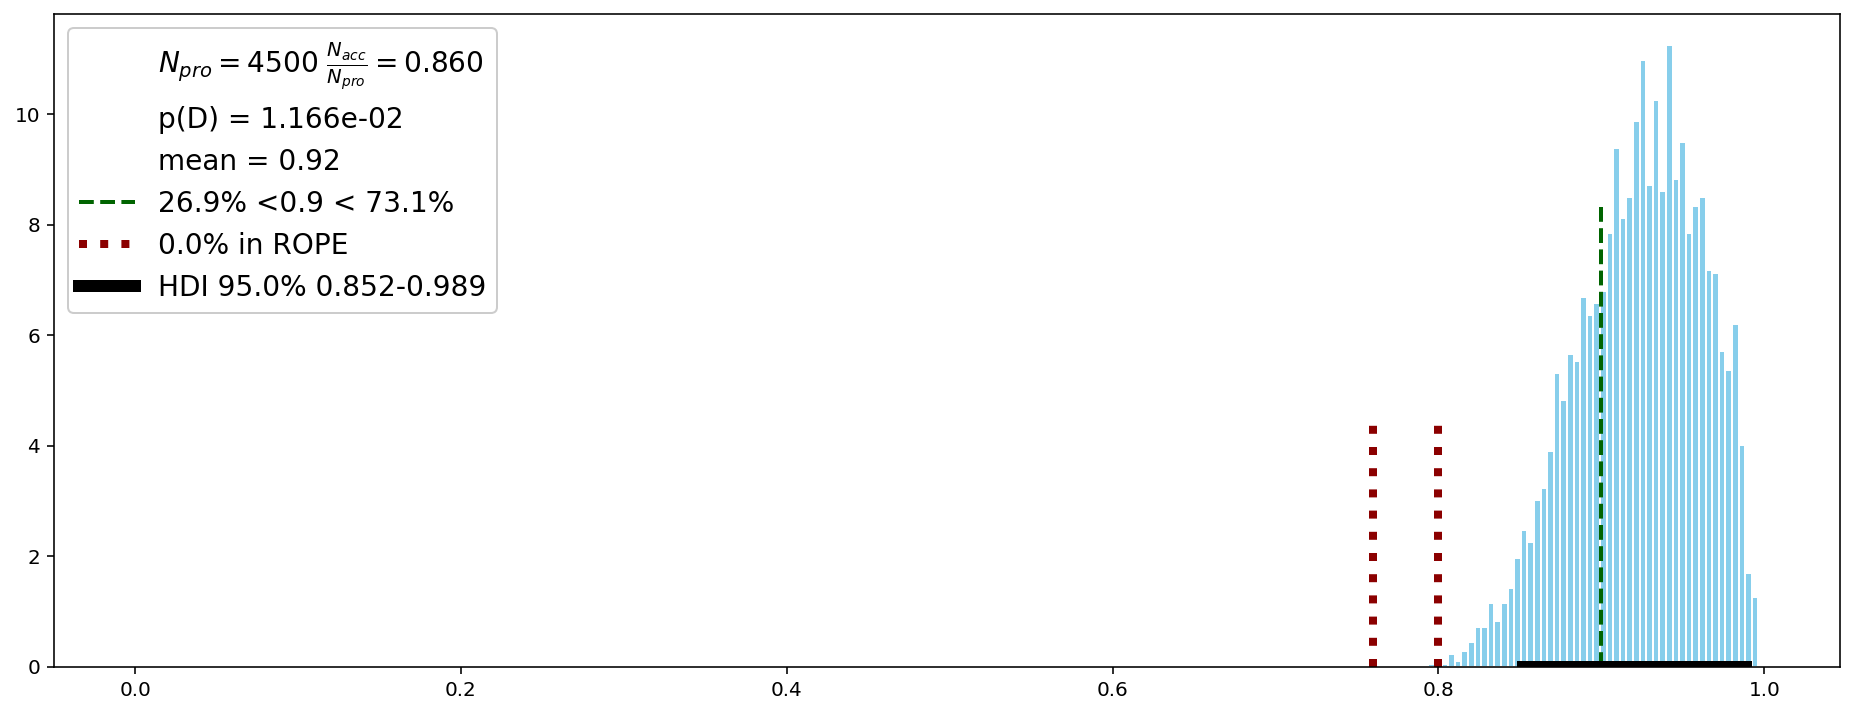

In [31]:
"""
07_BernMetropolisTemplate.py
Use this program as a template for experimenting with the Metropolis algorithm
applied to a single parameter called theta, defined on the interval [0,1].
"""

# Specify the data, to be used in the likelihood function.
# This is a vector with one component per flip,
# in which 1 means a "head" and 0 means a "tail".
my_data = np.array([0,1,1])  # 11 heads, 2 tail

# Define the Bernoulli likelihood function, p(D|theta).
# The argument theta could be a vector, not just a scalar.
def likelihood(theta, data):
    theta = np.array(theta) # ensure you have an array
    z = sum(data[data == 1])  # number of 1's in Data
    N = len(data)  # number of flips in Data
# Compute the likelihood of the Data for each value of Theta.
    if np.size(theta) == 1:  # if theta is an scalar
        p_data_given_theta = 0
        if theta < 1 and theta > 0:
            p_data_given_theta = theta**z * (1-theta)**(N-z)
    else: # if theta is an array
        p_data_given_theta = theta**z * (1-theta)**(N-z)
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        p_data_given_theta[(theta > 1) | (theta < 0)] = 0
    return p_data_given_theta


# Define the prior density function. For purposes of computing p(D),
# at the end of this program, we want this prior to be a proper density.
# The argument theta could be a vector, not just a scalar.
def prior(theta):
    """theta = np.array(theta) # ensure you have an array
# For kicks, here's a bimodal prior. To try it, uncomment the next 2 lines.
    #from scipy.stats import beta
    #prior = dbeta(np.minium(2*theta, 2*(1-theta)), 2, 2)
    if np.size(theta) == 1:  # if theta is an scalar
        prior = 0
        if theta < 1 and theta > 0:
            prior = 1
    else: # if theta is an array
        prior = np.ones(len(theta))  # uniform density over [0,1]
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        prior[(theta > 1) | (theta < 0)] = 0
    return prior"""
    return (1/1.5) * ((np.cos(4 * np.pi * theta) + 1) ** 2)



# Define the relative probability of the target distribution, 
# as a function of vector theta. For our application, this
# target distribution is the unnormalized posterior distribution.
def target_rel_prob(theta, data):
    target_rel_prob = likelihood(theta , data) * prior(theta)
    return target_rel_prob

# Specify the length of the trajectory, i.e., the number of jumps to try:
traj_length = 5000 # arbitrary large number
# Initialize the vector that will store the results:
trajectory = np.zeros(traj_length)
# Specify where to start the trajectory:
trajectory[0] = 0.99 # arbitrary value
# Specify the burn-in period:
burn_in = int(np.ceil(0.1 * traj_length)) # arbitrary number, less than traj_length
# Initialize accepted, rejected counters, just to monitor performance:
n_accepted = 0
n_rejected = 0
# Specify seed to reproduce same random walk:
np.random.seed(4745)

# Now generate the random walk. The 't' index is time or trial in the walk.
for t in range(traj_length-1):
    current_position = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    # The shape and variance of the proposal distribution can be changed
    # to whatever you think is appropriate for the target distribution.
    proposalSD = [.02, .2, 2.]
    proposed_jump = np.random.normal(loc=0 , scale=proposalSD[0], size=1)

#    # Compute the probability of accepting the proposed jump.
    prob_accept = np.minimum(1, 
                            target_rel_prob(current_position + proposed_jump, my_data)
                            / target_rel_prob(current_position, my_data))
#    # Generate a random uniform value from the interval [0,1] to
#    # decide whether or not to accept the proposed jump.
    if np.random.rand() < prob_accept:
        # accept the proposed jump
        trajectory[t+1] = current_position + proposed_jump
        # increment the accepted counter, just to monitor performance
        if t > burn_in:
            n_accepted += 1
    else:
        # reject the proposed jump, stay at current position
        trajectory[t+1] = current_position
        # increment the rejected counter, just to monitor performance
        if t > burn_in:
            n_rejected += 1


# Extract the post-burn_in portion of the trajectory.
accepted_traj = trajectory[burn_in:]
# End of Metropolis algorithm.



# Display rejected/accepted ratio in the plot.
mean_traj = np.mean(accepted_traj)
std_traj = np.std(accepted_traj)

plt.figure(figsize=(16,6)) # Brian added

plt.plot(0, label=r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(accepted_traj), (n_accepted/len(accepted_traj))), alpha=0)

# Evidence for model, p(D).

# Compute a,b parameters for beta distribution that has the same mean
# and stdev as the sample from the posterior. This is a useful choice
# when the likelihood function is Bernoulli.
a = mean_traj * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)
b = (1 - mean_traj) * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)

# For every theta value in the posterior sample, compute 
# dbeta(theta,a,b) / likelihood(theta)*prior(theta)
# This computation assumes that likelihood and prior are proper densities,
# i.e., not just relative probabilities. This computation also assumes that
# the likelihood and prior functions were defined to accept a vector argument,
# not just a single-component scalar argument.
wtd_evid = beta.pdf(accepted_traj, a, b) / (likelihood(accepted_traj, my_data) * prior(accepted_traj))
p_data = 1 / np.mean(wtd_evid)


# Display p(D) in the graph
plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)

# Display the posterior.
ROPE = np.array([0.76, 0.8])
mcmc_info = plot_post(accepted_traj, xlab='theta', show_mode=False, comp_val=0.9, ROPE=ROPE)


# Uncomment next line if you want to save the graph.
plt.show()

This clearly shows that our SD is too small. We are getting stuck in the far hump and because the step size is always really small, it would take an astronomically large amount of time to walk parameter space well enough to get a good distribution that looked like the graph from part B.